In [1]:
library(ggplot2)
library(reshape2)
library(RColorBrewer)
suppressMessages(library(dplyr))
library(stringr)
suppressMessages(library(tidyr))
theme_set(theme_bw())
options(repr.plot.width=7, repr.plot.height=4)
isotypes = c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')

paired_positions = c('X1.72'='1:72', 'X2.71'='2:71', 'X3.70'='3:70', 'X4.69'='4:69', 'X5.68'='5:68', 'X6.67'='6:67', 'X7.66'='7:66', 'X8.14'='8:14', 'X9.23'='9:23', 'X10.25'='10:25', 'X10.45'='10:45', 'X11.24'='11:24', 'X12.23'='12:23', 'X13.22'='13:22', 'X15.48'='15:48','X18.55'='18:55', 'X19.56'='19:56', 'X22.46'='22:46', 'X26.44'='26:44', 'X27.43'='27:43', 'X28.42'='28:42', 'X29.41'='29:41', 'X30.40'='30:40', 'X31.39'='31:39', 'X49.65'='49:65', 'X50.64'='50:64', 'X51.63'='51:63', 'X52.62'='52:62', 'X53.61'='53:61', 'X54.58'='54:58')
paired_identities = c('GC', 'AU', 'UA', 'CG', 'GU', 'UG', 'Absent', 'PurinePyrimidine', 'PyrimidinePurine', 'StrongPair', 'WeakPair', 'AminoKeto', 'KetoAmino', 'Wobble', 'Paired', 'Bulge', 'Mismatched')
paired_colors = c('GC'='gray20', 'AU'='gray20', 'UA'='gray20', 'CG'='gray20', 'GU'='gray20', 'UG'='gray20', 'Absent'='gray20', 'PurinePyrimidine'='gray40', 'PyrimidinePurine'='gray40', 'StrongPair'='gray40', 'WeakPair'='gray40', 'AminoKeto'='gray40', 'KetoAmino'='gray40', 'Wobble'='gray40', 'Paired'='gray40', 'Bulge'='gray40', 'Mismatched'='gray40')

single_positions = c('X8'='8', 'X9'='9', 'X14'='14', 'X15'='15', 'X16'='16', 'X17'='17', 'X17a'='17a', 'X18'='18', 'X19'='19', 'X20'='20', 'X20a'='20a', 'X20b'='20b', 'X21'='21', 'X26'='26', 'X32'='32', 'X33'='33', 'X34'='34', 'X35'='35', 'X36'='36', 'X37'='37', 'X38'='38', 'X44'='44', 'X45'='45', 'X46'='46', 'X47'='47', 'X48'='48', 'X54'='54', 'X55'='55', 'X56'='56', 'X57'='57', 'X58'='58', 'X59'='59', 'X60'='60', 'X73'='73')
single_identities = c('A', 'C', 'G', 'U', 'Absent', 'Purine', 'Pyrimidine', 'Weak', 'Strong', 'Amino', 'Keto', 'B', 'D', 'H', 'V')
single_colors = c('A'='gray20', 'C'='gray20', 'G'='gray20', 'U'='gray20', 'Absent'='gray20', 'Purine'='gray40', 'Pyrimidine'='gray40', 'Weak'='gray40', 'Strong'='gray40', 'Amino'='gray40', 'Keto'='gray40', 'B'='gray40', 'D'='gray40', 'H'='gray40', 'V'='gray40')

# Introduction

We look for isotype-specific, clade-specific, and clade-isotype-specific identity elements.

- **Isotype-specific** IDEs are verified by:
    - for the isotype in question, checking that 90% of the tRNAs for each clade contain the IDE
    - for the isotype in question, ensuring that the IDE exists at above 50% frequency for all species 
- **Clade-specific** IDEs are verified by:
    - for the clade in question, checking that 90% of the tRNAs for each isotype contain the IDE
    - ensuring that the IDE exists at above 50% frequency for all species and each isotype
- **Clade and isotype-specific** IDEs are verified by:
    - for the clade and isotype in question, checking that 90% of the tRNAs contain the IDE
    - for the isotype in question, ensuring that the IDE exists at above 50% frequency for all species
    
# Data wrangling
## Data import

In [2]:
identities = read.delim('identities.tsv', sep='\t', stringsAsFactors=FALSE)
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)
identities = identities %>% filter(!restrict, !(isotype %in% c('SeC', 'Sup')))
positions = colnames(identities)[which(str_detect(colnames(identities), "X\\d+\\.\\d+$"))]
positions = c(positions, 'X8', 'X9', 'X14', 'X15', 'X16', 'X17', 'X17a', 'X18', 'X19', 'X20', 'X20a', 'X20b', 'X21', 'X26', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X44', 'X45', 'X46', 'X47', 'X48', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X73')

## Get frequencies

In [3]:
clade_iso_freqs = identities %>%
  filter(!restrict) %>%
  select(match(c('clade', 'isotype', positions), colnames(identities))) %>%
  gather(positions, bases, -clade, -isotype) %>%
  group_by(clade, isotype, positions, bases) %>%
  tally %>%
  group_by(clade, isotype, positions) %>%
  summarize(A = sum(n[bases == "A"]),
            C = sum(n[bases == "C"]),
            G = sum(n[bases == "G"]),
            U = sum(n[bases == "U"]),
            GC = sum(n[bases == "G:C"]),
            AU = sum(n[bases == "A:U"]),
            UA = sum(n[bases == "U:A"]),
            CG = sum(n[bases == "C:G"]),
            GU = sum(n[bases == "G:U"]),
            UG = sum(n[bases == "U:G"]),
            Paired = sum(n[bases %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G")]),
            Absent = sum(n[bases %in% c("-", ".", "-:-")]),
            Bulge = sum(n[bases %in% c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U")]),
            Mismatched = sum(n[bases %in% c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C")]),
            Purine = sum(n[(bases %in% c("A", "G")) & (n / sum(n) >= 0.05)]),
            Pyrimidine = sum(n[(bases %in% c("C", "U")) & (n / sum(n) >= 0.05)]),
            Weak = sum(n[(bases %in% c("A", "U")) & (n / sum(n) >= 0.05)]),
            Strong = sum(n[(bases %in% c("G", "C")) & (n / sum(n) >= 0.05)]),
            Amino = sum(n[(bases %in% c("A", "C")) & (n / sum(n) >= 0.05)]),
            Keto = sum(n[(bases %in% c("G", "U")) & (n / sum(n) >= 0.05)]),
            B = sum(n[(bases %in% c("C", "G", "U")) & (n / sum(n) >= 0.05)]),
            D = sum(n[(bases %in% c("A", "G", "U")) & (n / sum(n) >= 0.05)]),
            H = sum(n[(bases %in% c("A", "C", "U")) & (n / sum(n) >= 0.05)]),
            V = sum(n[(bases %in% c("A", "C", "G")) & (n / sum(n) >= 0.05)]),
            D = sum(n[(bases %in% c("A", "G", "U")) & (n / sum(n) >= 0.05)]),
            PurinePyrimidine = sum(n[(bases %in% c("A:U", "G:C")) & (n / sum(n) >= 0.05)]),
            PyrimidinePurine = sum(n[(bases %in% c("U:A", "C:G")) & (n / sum(n) >= 0.05)]),
            StrongPair = sum(n[(bases %in% c("G:C", "C:G")) & (n / sum(n) >= 0.05)]),
            WeakPair = sum(n[(bases %in% c("A:U", "U:A")) & (n / sum(n) >= 0.05)]),
            AminoKeto = sum(n[(bases %in% c('AU', 'CG', 'AminoKeto')) & (n / sum(n) >= 0.05)]),
            KetoAmino = sum(n[(bases %in% c('UA', 'GC', 'KetoAmino')) & (n / sum(n) >= 0.05)]),
            Wobble = sum(n[(bases %in% c("G:U", "U:G")) & (n / sum(n) >= 0.05)])) %>%
  mutate(clade_iso_pos_total = A + C + G + U + Paired + Absent + Bulge + Mismatched) %>%
  gather(feature, n, -clade, -isotype, -positions, -clade_iso_pos_total) %>%
  mutate(freq = n/clade_iso_pos_total)

code_groups = c('A'=1, 'C'=1, 'G'=1, 'U'=1, 'Absent'=1, 
                'GC'=1, 'AU'=1, 'UA'=1, 'CG'=1, 'GU'=1, 'UG'=1,
                'Purine'=2, 'Pyrimidine'=2,
                'Weak'=3, 'Strong'=3, 'Amino'=3, 'Keto'=3,
                'B'=4, 'D'=4, 'H'=4, 'V'=4,
                'StrongPair'=2, 'WeakPair'=2, 'Wobble'=2,
                'PurinePyrimidine'=3, 'PyrimidinePurine'=3, 'AminoKeto'=3, 'KetoAmino'=3,
                'Paired'=4, 'Mismatched'=4, 'Bulge'=4)

In [4]:
# remove duplicates
best_freqs = clade_iso_freqs %>%
  filter(freq > 0.9) %>%
  group_by(clade, isotype, positions) %>%
  arrange(code_groups[feature], desc(freq)) %>%
  filter(row_number(positions) == 1)

# Consensus sequence features

In [5]:
get_consensus_feature = function(position, codes) {
  position = unique(position)
  best_codes = resolve_code(codes) # returns a vector of all possible combinations of bases. Note that this is not limited to the basic combinations given by the codes variable.
  if (length(position) != 1) stop("Multiple positions passed to function")
  if (length(codes) != 126) return("N/A") # make sure that each isotype/clade is represented
  if (length(best_codes) == 0) return("N/A")
  codes = list(A="A", C="C", G="G", U="U", Absent=c("-", ".", "-:-"), Purine=c("A", "G"), Pyrimidine=c("C", "U"), Weak=c("A", "U"), Strong=c("G", "C"), Amino=c("A", "C"), Keto=c("G", "U"), B=c("C", "G", "U"), D=c("A", "G", "U"), H=c("A", "C", "U"), V=c("A", "C", "G"), D=c("A", "G", "U"), GC="G:C", AU="A:U", UA="U:A", CG="C:G", GU="G:U", UG= "U:G", PurinePyrimidine=c("A:U", "G:C"), PyrimidinePurine=c("U:A", "C:G"), AminoKeto=c("A:U", "C:G"), KetoAmino=c("U:A", "G:C"), StrongPair=c("G:C", "C:G"), WeakPair=c("A:U", "U:A"), Wobble=c("G:U", "U:G"), Paired=c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"), Bulge=c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U"), Mismatched=c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C"))   # for each possible code, check each species
  # for each possible code, check each species
  # this ensures that we consider other IDEs if the most specific one fails the species check. For example, if "Purine" fails, we also consider "V"
  species_check = sapply(best_codes, function(code) {
    codes_str = paste0("c('", paste0(codes[[code]], collapse="', '"), "')")
    df = identities %>%
           select_('species', 'isotype', position) %>%
           group_by_('species', 'isotype') %>% 
           summarize_(match = paste0("sum(", position, " %in% ", codes_str, ")"),
                      miss = paste0("sum(!(", position, " %in% ", codes_str, "))")) %>%
           mutate(ubiquitous = (match / (match + miss)) > 0.1)
    all(df$ubiquitous)
  })
  ide = names(species_check[species_check])[1]
  return(ifelse(is.na(ide), "N/A", ide))
}

resolve_code = function(codes) {
  codes = unique(codes)
  x = c(A = all(codes %in% 'A'),
        C = all(codes %in% 'C'),
        G = all(codes %in% 'G'),
        U = all(codes %in% 'U'),
        Absent = all(codes %in% 'Absent'),
        Purine = all(codes %in% c('A', 'G', 'Purine')),
        Pyrimidine = all(codes %in% c('C', 'U', 'Pyrimidine')),
        Weak = all(codes %in% c('A', 'U', 'Weak')),
        Strong = all(codes %in% c('G', 'C', 'Strong')),
        Amino = all(codes %in% c('A', 'C', 'Amino')),
        Keto = all(codes %in% c('G', 'U', 'Keto')),
        B = all(codes %in% c('C', 'G', 'U', 'B', 'Strong', 'Pyrimidine', 'Keto')),
        D = all(codes %in% c('A', 'G', 'U', 'D', 'Purine', 'Weak', 'Keto')),
        H = all(codes %in% c('A', 'C', 'U', 'H', 'Amino', 'Weak', 'Pyrimidine')),
        V = all(codes %in% c('A', 'C', 'G', 'V', 'Amino', 'Purine', 'Strong')),
        GC = all(codes %in% 'GC'),
        AU = all(codes %in% 'AU'),
        UA = all(codes %in% 'UA'),
        CG = all(codes %in% 'CG'),
        GU = all(codes %in% 'GU'),
        UG = all(codes %in% 'UG'),
        PurinePyrimidine = all(codes %in% c('AU', 'GC', 'PurinePyrimidine')),
        PyrimidinePurine = all(codes %in% c('UA', 'CG', 'PyrimidinePurine')),
        StrongPair = all(codes %in% c('GC', 'CG', 'StrongPair')),
        WeakPair = all(codes %in% c('AU', 'UA', 'WeakPair')),
        AminoKeto = all(codes %in% c('AU', 'CG', 'AminoKeto')),
        KetoAmino = all(codes %in% c('UA', 'GC', 'KetoAmino')),
        Wobble = all(codes %in% c('GU', 'UG', 'Wobble')),
        Paired = all(codes %in% c('AU', 'UA', 'CG', 'GC', 'GU', 'UG', 'Paired', 'PurinePyrimidine', 'PyrimidinePurine', 'StrongPair', 'WeakPair', 'AminoKeto', 'KetoAmino', 'Wobble')),
        Bulge = all(codes %in% 'Bulge'),
        Mismatched = all(codes %in% c('AA', 'GG', 'CC', 'UU', 'AG', 'AC', 'CA', 'CU', 'GA', 'UC', 'Mismatched')))
  return(names(x[which(x)]))
}

In [6]:
consensus = best_freqs %>%
  group_by(positions) %>% 
  summarize(identity = get_consensus_feature(positions, feature)) %>%
  filter(identity != "N/A")
consensus

,positions,identity
1,X10.25,Paired
2,X11.24,Paired
3,X14,A
4,X18,Purine
5,X18.55,Paired
6,X19,G
7,X19.56,Paired
8,X2.71,Paired
9,X29.41,Paired
10,X32,Pyrimidine


# Isotype-specific IDEs

In [7]:
get_isotype_IDE = function(isotype, position, codes) {
  isotype = unique(isotype)
  position = unique(position)
  valid_codes = resolve_code(codes) # returns a vector of all possible combinations of bases. Note that this is not limited to the basic combinations given by the codes variable.
  if (length(isotype) != 1) stop("Multiple isotypes passed to function")
  if (length(position) != 1) stop("Multiple positions passed to function")
  if (length(codes) != 6) return("N/A") # make sure that each clade is represented
  if (length(valid_codes) == 0) return("N/A")
  codes = list(A="A", C="C", G="G", U="U", Absent=c("-", ".", "-:-"), Purine=c("A", "G"), Pyrimidine=c("C", "U"), Weak=c("A", "U"), Strong=c("G", "C"), Amino=c("A", "C"), Keto=c("G", "U"), B=c("C", "G", "U"), D=c("A", "G", "U"), H=c("A", "C", "U"), V=c("A", "C", "G"), D=c("A", "G", "U"), GC="G:C", AU="A:U", UA="U:A", CG="C:G", GU="G:U", UG= "U:G", PurinePyrimidine=c("A:U", "G:C"), PyrimidinePurine=c("U:A", "C:G"), AminoKeto=c("A:U", "C:G"), KetoAmino=c("U:A", "G:C"), StrongPair=c("G:C", "C:G"), WeakPair=c("A:U", "U:A"), Wobble=c("G:U", "U:G"), Paired=c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"), Bulge=c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U"), Mismatched=c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C"))   # for each possible code, check each species
  # this ensures that we consider other IDEs if the most specific one fails the species check. For example, if "Purine" fails, we also consider "V"
  for (code in valid_codes) {
    codes_str = paste0("c('", paste0(codes[[code]], collapse="', '"), "')")
    df = identities %>%
           select_('species', 'isotype', position) %>%
           filter_(paste0("isotype == '", isotype, "'")) %>%
           group_by_('species') %>% 
           summarize_(match = paste0("sum(", position, " %in% ", codes_str, ")"),
                      miss = paste0("sum(!(", position, " %in% ", codes_str, "))")) %>%
           mutate(ubiquitous = (match / (match + miss)) > 0.1)
    if (all(df$ubiquitous)) return(code)
  }
  return("N/A")
}

In [8]:
isotype_specific = best_freqs %>%
  group_by(isotype, positions) %>% 
  summarize(identity = get_isotype_IDE(isotype, positions, feature)) %>%
  filter(identity != "N/A")

In [9]:
nrow(isotype_specific %>% filter(!(positions %in% consensus$positions)))

[1] 658

There are 562 isotype-specific IDEs. I'll summarize in a couple of ways.

This first plot shows the number of IDEs that are specific to $x$ number of isotypes. So the first bar shows that there are 77 position + IDE combinations belonging to only one isotype. Which brings up the question - what is an isotype-specific element? What if multiple isotypes share an identity element? This plot shows the spread of how many isotypes share how many IDEs.

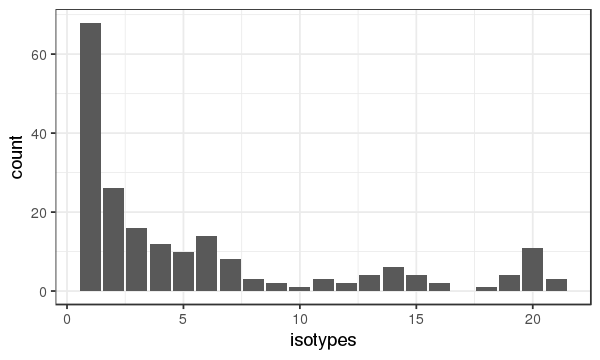

In [10]:
options(repr.plot.width=5, repr.plot.height=3)
isotype_specific %>% group_by(positions, identity) %>%
  summarize(isotypes = n()) %>%
  ggplot() + geom_bar(aes(x=isotypes))

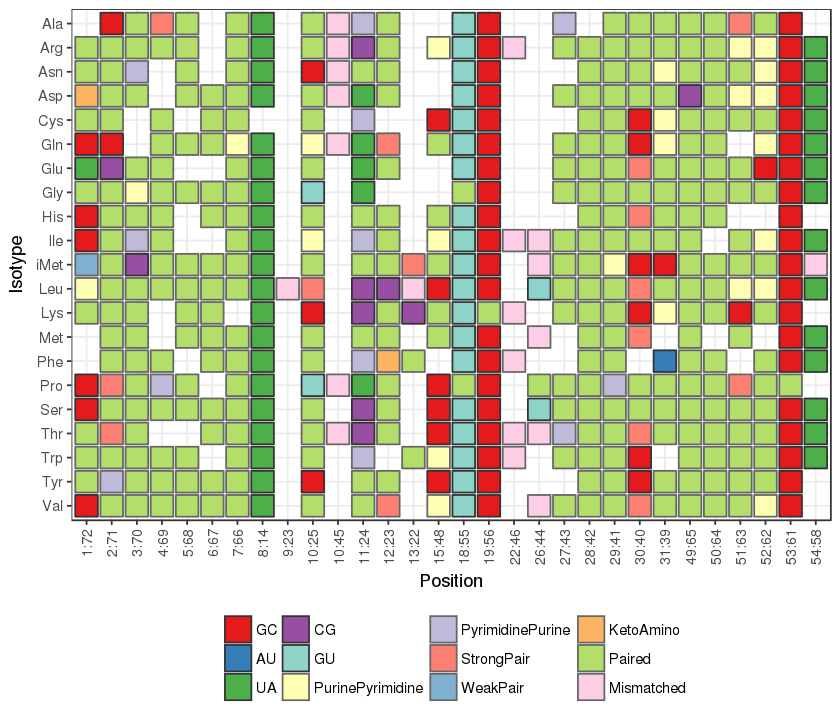

In [11]:
options(repr.plot.width=7, repr.plot.height=6)
isotype_specific %>% 
  filter(str_detect(positions, '\\.')) %>%
  mutate(positions=factor(positions, names(paired_positions))) %>%
  mutate(identity=factor(identity, paired_identities)) %>%
  ggplot() + geom_tile(aes(x=positions, y=isotype, fill=identity, color=identity), width=0.9, height=0.9, size=0.5) + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), legend.position='bottom') + 
    scale_x_discrete(labels=paired_positions) +
    scale_y_discrete(limits=rev(isotypes)) +
    scale_color_manual(values=paired_colors) +
    scale_fill_manual(values=c(brewer.pal(4, "Set1"), brewer.pal(12, "Set3"))) +
    guides(fill=guide_legend(title=NULL), color=guide_legend(title=NULL)) + 
    xlab('Position') + ylab('Isotype')

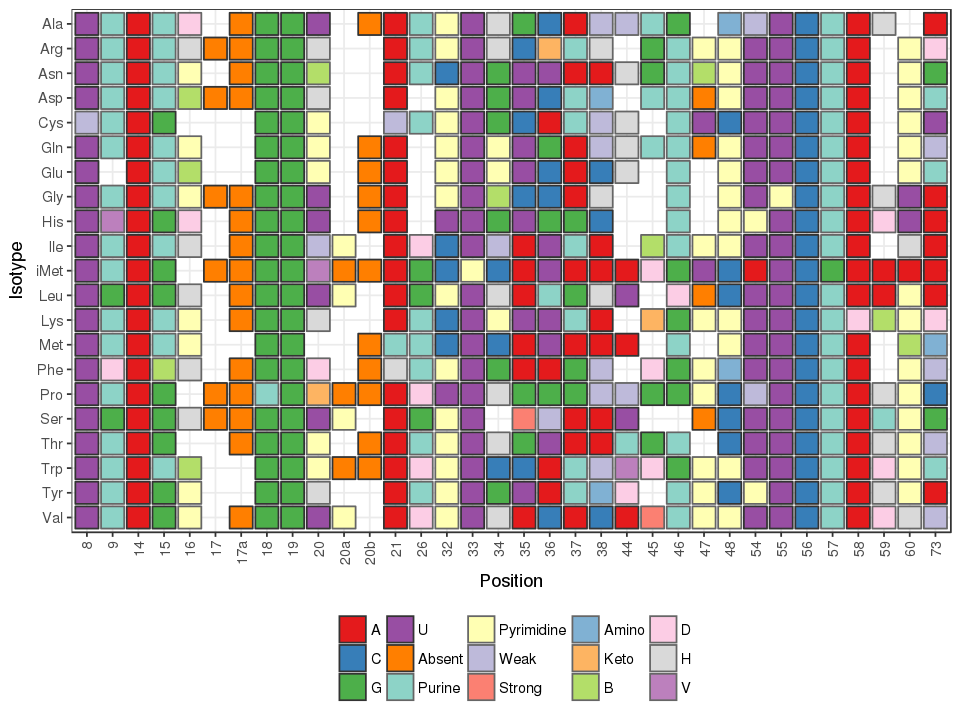

In [12]:
options(repr.plot.width=8, repr.plot.height=6)
isotype_specific %>% 
  filter(!str_detect(positions, '\\.')) %>%
  mutate(positions=factor(positions, names(single_positions))) %>%
  mutate(identity=factor(identity, single_identities)) %>%
  ggplot() + geom_tile(aes(x=positions, y=isotype, fill=identity, color=identity), width=0.9, height=0.9, size=0.5) + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), legend.position='bottom') + 
    scale_x_discrete(labels=single_positions) +
    scale_y_discrete(limits=rev(isotypes)) + 
    scale_color_manual(values=single_colors) +
    scale_fill_manual(values=c(brewer.pal(5, "Set1"), brewer.pal(12, "Set3"))) +
    guides(fill=guide_legend(title=NULL), color=guide_legend(title=NULL)) + 
    xlab('Position') + ylab('Isotype')

# Clade-specific IDEs

In [13]:
get_clade_IDE = function(clade, position, codes) {
  clade = unique(clade)
  position = unique(position)
  valid_codes = resolve_code(codes) # returns a vector of all possible combinations of bases. Note that this is not limited to the basic combinations given by the codes variable.
  if (length(clade) != 1) stop("Multiple clades passed to function")
  if (length(position) != 1) stop("Multiple positions passed to function")
  if (length(codes) != 21) return("N/A") # make sure that each isotype is represented
  if (length(valid_codes) == 0) return("N/A")
  codes = list(A="A", C="C", G="G", U="U", Absent=c("-", ".", "-:-"), Purine=c("A", "G"), Pyrimidine=c("C", "U"), Weak=c("A", "U"), Strong=c("G", "C"), Amino=c("A", "C"), Keto=c("G", "U"), B=c("C", "G", "U"), D=c("A", "G", "U"), H=c("A", "C", "U"), V=c("A", "C", "G"), D=c("A", "G", "U"), GC="G:C", AU="A:U", UA="U:A", CG="C:G", GU="G:U", UG= "U:G", PurinePyrimidine=c("A:U", "G:C"), PyrimidinePurine=c("U:A", "C:G"), AminoKeto=c("A:U", "C:G"), KetoAmino=c("U:A", "G:C"), StrongPair=c("G:C", "C:G"), WeakPair=c("A:U", "U:A"), Wobble=c("G:U", "U:G"), Paired=c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"), Bulge=c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U"), Mismatched=c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C"))   # for each possible code, check each species
  # for each possible code, check each species
  # this ensures that we consider other IDEs if the most specific one fails the species check. For example, if "Purine" fails, we also consider "V"
  for (code in valid_codes) {
    codes_str = paste0("c('", paste0(codes[[code]], collapse="', '"), "')")
    df = identities %>% 
           select_('species', 'clade', position) %>%    
           filter_(paste0("clade == '", clade, "'")) %>%
           group_by_('species') %>% 
           summarize_(match = paste0("sum(", position, " %in% ", codes_str, ")"),
                      miss = paste0("sum(!(", position, " %in% ", codes_str, "))")) %>%
           mutate(ubiquitous = (match / (match + miss)) > 0.1)
    if (all(df$ubiquitous)) return(code)
  }
  return("N/A")
}

In [14]:
clade_specific = best_freqs %>%
  group_by(clade, positions) %>% 
  summarize(identity = get_clade_IDE(clade, positions, feature)) %>%
  filter(identity != "N/A")

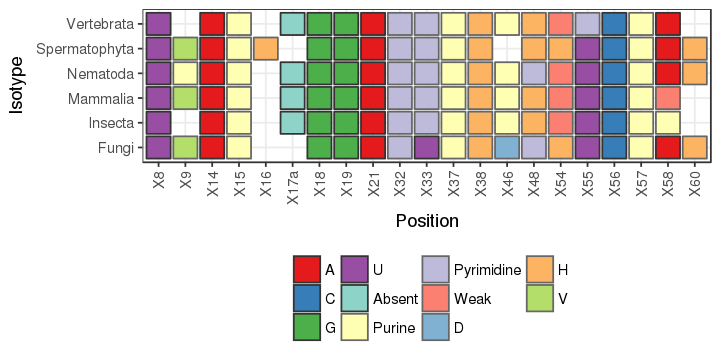

In [15]:
options(repr.plot.width=6, repr.plot.height=3)
clade_specific %>% 
  filter(!str_detect(positions, '\\.')) %>%
  mutate(positions=factor(positions, names(single_positions))) %>%
  mutate(identity=factor(identity, single_identities)) %>%
  ggplot() + geom_tile(aes(x=positions, y=clade, fill=identity, color=identity), width=0.9, height=0.9, size=0.5) + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), legend.position='bottom') + 
    scale_x_discrete(labels=paired_positions) +
    scale_color_manual(values=single_colors) +
    scale_fill_manual(values=c(brewer.pal(4, "Set1"), brewer.pal(12, "Set3"))) +
    guides(fill=guide_legend(title=NULL), color=guide_legend(title=NULL)) + 
    xlab('Position') + ylab('Isotype')

There is seemingly some discrepencies between this and the isotype-specific results. For instance, position 15 is listed as purine among all clades, yet some isotypes show a different identity (not A, G, or R). 

Apparently, _fungal alanine tRNAs_ fail the species check for purine, but _fungal tRNAs_ do not. It's redundant to check for clade at the same time with the species check - species belong to a clade, but species do not belong to an isotype. Thus, clade specificity is more relaxed: clades as a whole can contain a clade-specific IDE even when a specific isotype within the clade doesn't qualify.

It's worth stepping back and considering the evolutionary perspective. Isotypes (mostly) evolve independently of one another, under the constraints of specificity. It's unlikely for all synthetases and tRNAs within a common ancestor to be directed en masse to evolve to reject a particular identity element. One case I can see this happening is a virus-mediated event where a particular identity element is targeted. 

So is the definition of "clade-specific" useful? Does tRNA and synthetase evolution operate at the organism level or at the isotype level?

# Clade-isotype-specific IDEs

In [16]:
get_clade_isotype_IDE = function(clade, isotype, position, codes) {
  clade = unique(clade)
  isotype = unique(isotype)
  position = unique(position)
  valid_codes = resolve_code(codes) # returns a vector of all possible combinations of bases. Note that this is not limited to the basic combinations given by the codes variable.
  if (length(clade) != 1) stop("Multiple clades passed to function")
  if (length(isotype) != 1) stop("Multiple clades passed to function")
  if (length(position) != 1) stop("Multiple positions passed to function")
  if (length(valid_codes) == 0) return("N/A")
  codes = list(A="A", C="C", G="G", U="U", Absent=c("-", ".", "-:-"), Purine=c("A", "G"), Pyrimidine=c("C", "U"), Weak=c("A", "U"), Strong=c("G", "C"), Amino=c("A", "C"), Keto=c("G", "U"), B=c("C", "G", "U"), D=c("A", "G", "U"), H=c("A", "C", "U"), V=c("A", "C", "G"), D=c("A", "G", "U"), GC="G:C", AU="A:U", UA="U:A", CG="C:G", GU="G:U", UG= "U:G", PurinePyrimidine=c("A:U", "G:C"), PyrimidinePurine=c("U:A", "C:G"), AminoKeto=c("A:U", "C:G"), KetoAmino=c("U:A", "G:C"), StrongPair=c("G:C", "C:G"), WeakPair=c("A:U", "U:A"), Wobble=c("G:U", "U:G"), Paired=c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"), Bulge=c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U"), Mismatched=c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C"))   # for each possible code, check each species
  # for each possible code, check each species
  # this ensures that we consider other IDEs if the most specific one fails the species check. For example, if "Purine" fails, we also consider "V"
  for (code in valid_codes) {
    codes_str = paste0("c('", paste0(codes[[code]], collapse="', '"), "')")
    df = identities %>% 
           select_('species', 'isotype', 'clade', position) %>%    
           filter_(paste0("clade == '", clade, "' & isotype == '", isotype, "'")) %>%
           group_by_('species') %>% 
           summarize_(match = paste0("sum(", position, " %in% ", codes_str, ")"),
                      miss = paste0("sum(!(", position, " %in% ", codes_str, "))")) %>%
           mutate(ubiquitous = (match / (match + miss)) > 0.1)
    if (all(df$ubiquitous)) return(code)
  }
  return("N/A")
}

In [17]:
clade_isotype_specific = best_freqs %>%
  group_by(clade, isotype, positions) %>% 
  summarize(identity = get_clade_isotype_IDE(clade, isotype, positions, feature)) %>%
  filter(identity != "N/A")

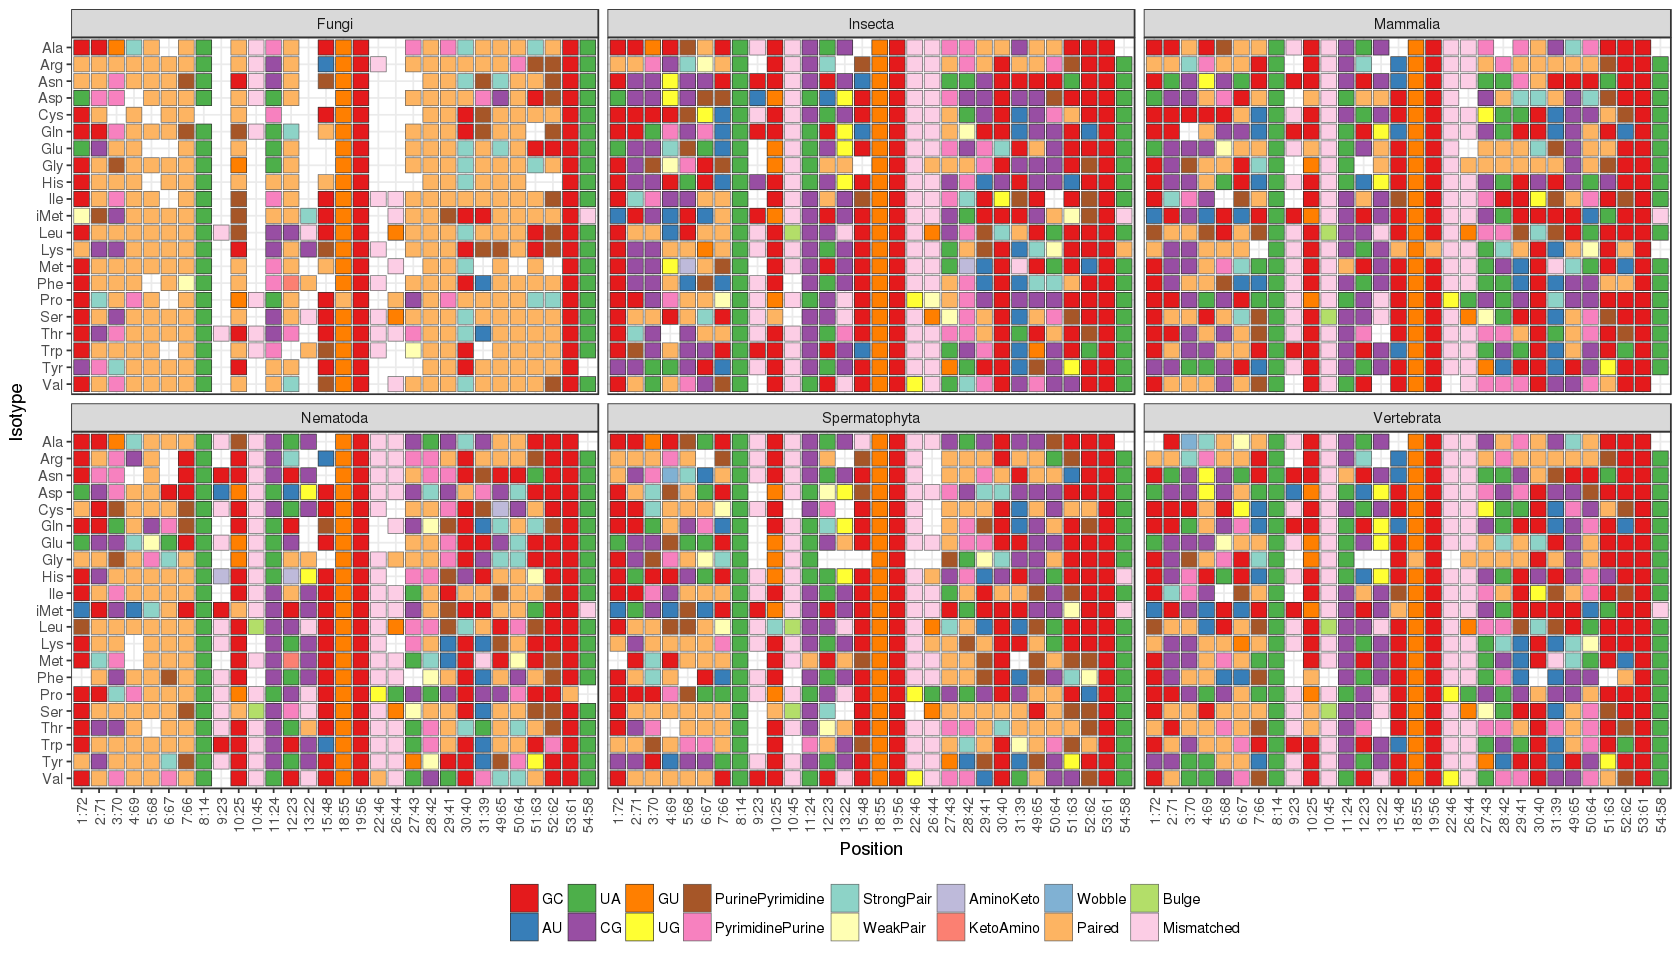

In [18]:
options(repr.plot.width=14, repr.plot.height=8)
clade_isotype_specific %>% 
  filter(str_detect(positions, '\\.')) %>%
  mutate(positions=factor(positions, names(paired_positions))) %>%
  mutate(identity=factor(identity, paired_identities)) %>%
  ggplot() + geom_tile(aes(x=positions, y=isotype, fill=identity, color=identity), width=0.9, height=0.9, size=0.2) + 
    facet_wrap(~ clade, nrow=2) + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), legend.position="bottom") +
    scale_x_discrete(labels=paired_positions) +
    scale_y_discrete(limits=rev(isotypes)) +
    scale_color_manual(values=paired_colors) +
    scale_fill_manual(values=c(brewer.pal(8, "Set1"), brewer.pal(12, "Set3"))) +
    guides(fill=guide_legend(title=NULL, nrow=2), color=guide_legend(title=NULL, nrow=2)) + 
    xlab('Position') + ylab('Isotype')

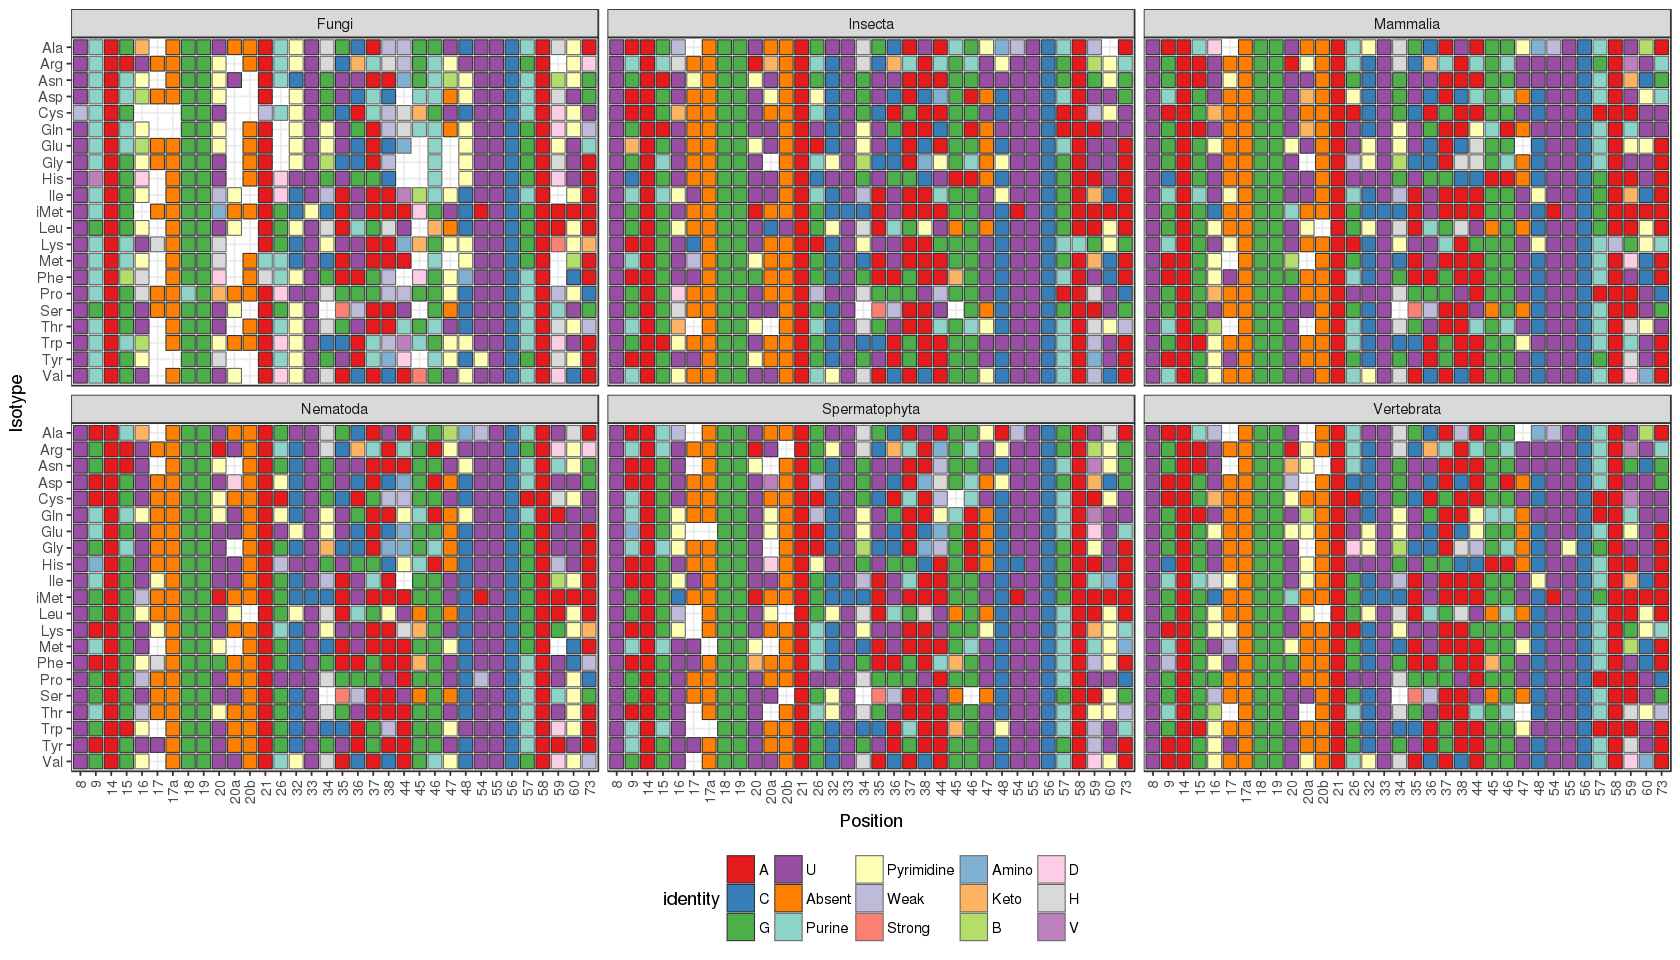

In [19]:
options(repr.plot.width=14, repr.plot.height=8)
clade_isotype_specific %>% 
  filter(!str_detect(positions, '\\.')) %>%
  mutate(positions=factor(positions, names(single_positions))) %>%
  mutate(identity=factor(identity, single_identities)) %>%
  ggplot() + geom_tile(aes(x=positions, y=isotype, fill=identity, color=identity), width=0.9, height=0.9, size=0.3) + 
    facet_wrap(~ clade, nrow=2) +
    scale_x_discrete(labels=single_positions) +
    scale_y_discrete(limits=rev(isotypes)) +
    scale_color_manual(values=single_colors) +
    scale_fill_manual(values=c(brewer.pal(5, "Set1"), brewer.pal(12, "Set3"))) +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), legend.position="bottom") +
    xlab('Position') + ylab('Isotype') +
    theme(legend.position="bottom")

# Export data

In [20]:
save(clade_iso_freqs, file='clade-isotype-freqs.RData')
save(best_freqs, file='best-freqs.RData')
save(isotype_specific, file='isotype-specific.RData')
save(clade_isotype_specific, file='clade-isotype-specific.RData')
save(consensus, file='consensus-IDEs.RData')